In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

/home/apakiman/anaconda3/envs/TF-keras/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-23 16:15:18.103611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 16:15:18.141477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 16:15:18.142178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:15:18.819309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPUs available.


2023-08-23 16:15:19.370132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 16:15:19.371009: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
(dataset_train_original, dataset_validate_original), infor = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[90%:]"], # pretending we don't have a big dataset
                                          # dataset is already shuffled
    as_supervised=True,
    with_info=True
)

# Note
Do caching before augmentation, no augmentation on validation

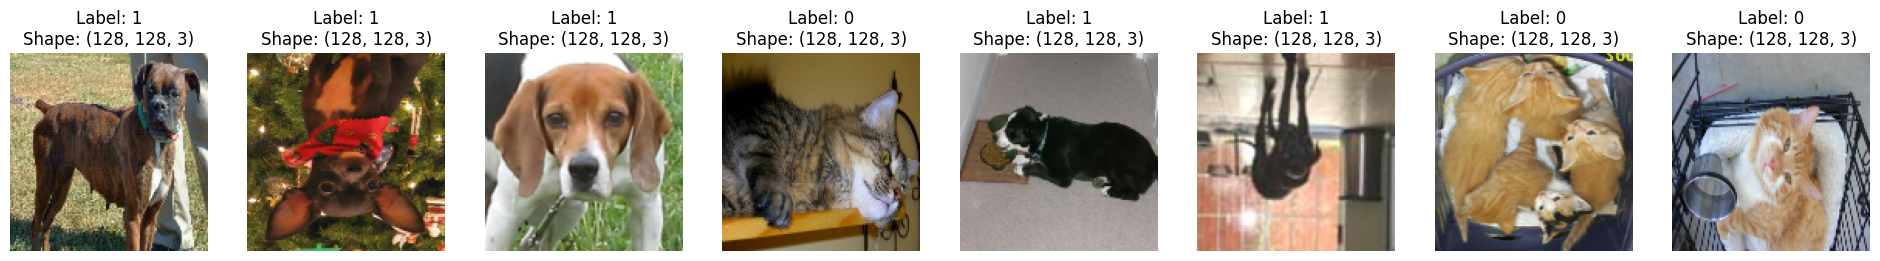

In [3]:
def encode(image, label, image_size=(128, 128)):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)
    return image, label
dataset = dataset_train_original.map(lambda image, label: encode(image, label))

def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    return image_augmented, label

dataset = dataset_train_original.map(lambda image, label: encode(image, label))
dataset = dataset.map(lambda image, label: augment(image, label))

num_samples = 8
index = 1
plt.figure(figsize=(24, 4))
for image, label in dataset.take(num_samples):
    plt.subplot(1, num_samples, index)
    plt.imshow(image)
    plt.title(f"Label: {label}\nShape: {image.shape}")
    plt.axis("off")
    index += 1

In [4]:
dataset_train_augmented = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train_augmented = dataset_train_augmented.cache()
dataset_train_augmented = dataset_train_augmented.map(lambda image, label: augment(image, label))
dataset_train_augmented = dataset_train_augmented.shuffle(2500)
dataset_train_augmented = dataset_train_augmented.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

In [5]:
from tensorflow import keras
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp, fixed=False):

    if not fixed:

        f = hp.Int(name="f", min_value=64, max_value=112, step=16)    # start size
        n = hp.Int(name="n", min_value=1, max_value=2, step=1)    # number of reapet
        m = hp.Int(name="m", min_value=3, max_value=5, step=1)    # number of unit repeat
        k = hp.Int(name="k", min_value=3, max_value=5, step=2)    # kernel size
        d = hp.Int(name="d", min_value=32, max_value=128, step=32)    # dense layer size
        p = hp.Int(name="p", min_value=2, max_value=5, step=2)    # max pooling

    else:
        hp = HyperParameters()
        f = hp.Fixed("f", value=32)
        n = hp.Fixed("n", value=2)
        m = hp.Fixed("m", value=3)
        k = hp.Fixed("k", value=3)
        d = hp.Fixed("d", value=128)
        p = hp.Fixed("p", value=2)



    unit_list = [
        layers.Conv2D(f, (k,k), padding="same", activation="relu", input_shape=(128, 128, 3)),
        layers.MaxPooling2D(p,p)]
    i = 1

    for mi in range(m):
        for ni in range(i,n):
            unit_list+=  [
                layers.Conv2D(f*(mi+1), (k,k), padding="same", activation="relu"),
                layers.MaxPooling2D(p,p),
            ]
        i = 0

    model = keras.Sequential(
        unit_list + [
            layers.Flatten(),
            layers.Dense(d, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )
    
    model.compile(
        optimizer ='adam',
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    return model

/tmp/ipykernel_330543/1843349991.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [6]:
# tf.keras.clear_session()
model = build_model(None, fixed=True)
model.build()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [49]:
tuner = kt.BayesianOptimization(
    build_model, #hypermodel
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyper_tuning",
    overwrite=True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
f (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 112, 'step': 16, 'sampling': 'linear'}
n (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
m (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
k (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
d (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
p (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 2, 'sampling': 'linear'}


In [51]:
# make hyper parameter study
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
tuner.search(
    dataset_train_augmented,
    epochs=5,
    validation_data=dataset_validate,
    callbacks=callbacks,
    verbose=2,
)

Trial 1 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 00s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
80                |112               |f
1                 |1                 |n
4                 |5                 |m
5                 |3                 |k
32                |96                |d
2                 |4                 |p

Epoch 1/5


2023-08-23 15:04:53.523173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2023-08-23 15:05:00.066838: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2023-08-23 15:05:01.364192: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2023-08-23 15:05:07.859730: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.
2023-08-23 15:05:09.056867: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 671088640 exceeds 10% of free system memory.


19/19 - 186s - loss: 0.7129 - accuracy: 0.5129 - val_loss: 0.6928 - val_accuracy: 0.4987 - 186s/epoch - 10s/step
Epoch 2/5
19/19 - 185s - loss: 0.6925 - accuracy: 0.5150 - val_loss: 0.6899 - val_accuracy: 0.5017 - 185s/epoch - 10s/step
Epoch 3/5


KeyboardInterrupt: 

# Dropout

In [7]:
tf.keras.backend.clear_session()
epochs= 50

model =models.Sequential([
    layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Dropout((.05)),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout((.1)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout((.15)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout((.2)),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout((.25)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout((.3)),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer ='adam',
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate,
)

Epoch 1/50


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 7/19 [==========>...................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5201 

KeyboardInterrupt: 

In [8]:
from tensorflow import keras
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp, fixed=False):

    f = hp.Int(name="f", min_value=64, max_value=112, step=32)    # start size
    n = hp.Int(name="n", min_value=2, max_value=2, step=1)    # number of reapet
    m = hp.Int(name="m", min_value=3, max_value=5, step=1)    # number of unit repeat
    k = hp.Int(name="k", min_value=3, max_value=3, step=2)    # kernel size
    d = hp.Int(name="d", min_value=32, max_value=128, step=32)    # dense layer size
    p = hp.Int(name="p", min_value=2, max_value=5, step=2)    # max pooling
    dr = hp.Float(name="dr", min_value=0.05, max_value=0.09, step=0.02)    # drop out

    unit_list = [
        layers.Conv2D(f, (k,k), padding="same", activation="relu", input_shape=(128, 128, 3)),
        layers.MaxPooling2D(p,p),
        layers.Dropout(dr)
        ]
    i = 1

    li =1
    for mi in range(m):
        for ni in range(i,n):
            unit_list+=  [
                layers.Conv2D(f*(mi+1), (k,k), padding="same", activation="relu"),
                layers.MaxPooling2D(p,p),
                layers.Dropout(dr*li)
            ]
            li +=1
        i = 0

    model = keras.Sequential(
        unit_list + [
            layers.Flatten(),
            layers.Dropout(dr*li),
            layers.Dense(d, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )
    
    model.compile(
        optimizer ='adam',
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    return model

In [75]:
tuner = kt.BayesianOptimization(
    build_model, #hypermodel
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyper_tuning_dropout",
    overwrite=True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
f (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 112, 'step': 32, 'sampling': 'linear'}
n (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
m (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
k (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 3, 'step': 2, 'sampling': 'linear'}
d (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
p (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
dr (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.09, 'step': 0.02, 'sampling': 'linear'}


In [77]:
# make hyper parameter study
tf.keras.backend.clear_session()
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
tuner.search(
    dataset_train_augmented,
    epochs=1,
    validation_data=dataset_validate,
    callbacks=callbacks,
    verbose=2,
)

Trial 3 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.4987102448940277
Total elapsed time: 00h 01m 56s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [78]:
top_n = 4
best_hps = tuner.get_best_hyperparameters(top_n)

# Print the best hyperparameters in a readable format
for bi in best_hps:
  for param, value in bi.values.items():
      print(f"{param}: {value}")

f: 64
n: 2
m: 3
k: 3
d: 64
p: 2
dr: 0.05
f: 96
n: 2
m: 4
k: 3
d: 128
p: 4
dr: 0.05
f: 64
n: 2
m: 5
k: 3
d: 96
p: 4
dr: 0.07


In [9]:

hp = HyperParameters()
f = hp.Fixed("f", value=64)
n = hp.Fixed("n", value=2)
m = hp.Fixed("m", value=3)
k = hp.Fixed("k", value=3)
d = hp.Fixed("d", value=64)
p = hp.Fixed("p", value=2)
dr = hp.Fixed("dr", value=0.05)    # drop out

model = build_model(hp, fixed=True)
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 64)       

In [10]:
history = model.fit(
    dataset_train_augmented,
    epochs=epochs+25,
    validation_data=dataset_validate,
)

Epoch 1/75
 3/19 [===>..........................] - ETA: 31s - loss: 0.7046 - accuracy: 0.4714